In [ ]:
#SECTION 1
import time
import itertools
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow_datasets as tfds

def load_dataset():
    (ds_train, ds_test), ds_info = tfds.load(
        'stanford_dogs',
        split=['train', 'test'],
        shuffle_files=True,
        as_supervised=True,
        with_info=True,
        data_dir='data/tfds'
    )
    return ds_train, ds_test, ds_info

##Section 1:
>The necessary modules are imported  on lines 2 - 6.

>The load_dataset() method loads the Stanford dogs dataset.

>The shuffle_files=True parameter indicates that the dataset files should be shuffled before loading. Shuffling the files helps in randomizing the order of data samples during training.

>The as_supervised=True parameter specifies that the data is loaded in a supervised format, where each example consists of an image and its corresponding label.

In [ ]:
#SECTION 2
total_set, ds_test, ds_info = load_dataset()
n_train_samples = tf.data.experimental.cardinality(total_set).numpy()
n_validation_samples = int(0.1 * n_train_samples)
n_train_samples = n_train_samples - n_validation_samples
ds_val = total_set.take(n_validation_samples)
ds_train = total_set.skip(n_validation_samples)

##Section 2

> The overall purpose of Section 2 is to split the dataset into training, validation, and test sets. The validation set is taken from the beginning of the training set, leaving the remaining samples for actual training. The total_set variable contains the entire dataset, while ds_train and ds_val are used for training and validation, respectively.

>The variables are stored globally.

In [ ]:
#SECTION 3
def preprocess_image(image, label, image_size=(224, 224)):
    image = tf.image.resize(image, image_size)
    image = tf.keras.applications.mobilenet.preprocess_input(image)
    return image, label


def prepare_for_training(ds_train,ds_val, ds_test, batch_size=32, image_size=(224, 224)):
    ds_train = ds_train.map(lambda x, y: preprocess_image(x, y, image_size), num_parallel_calls=tf.data.AUTOTUNE)
    ds_train = ds_train.batch(batch_size)
    ds_train = ds_train.prefetch(buffer_size=tf.data.AUTOTUNE)

    ds_val = ds_val.map(lambda x, y: preprocess_image(x, y, image_size), num_parallel_calls=tf.data.AUTOTUNE)
    ds_val = ds_val.batch(batch_size)
    ds_val = ds_val.prefetch(buffer_size=tf.data.AUTOTUNE)

    ds_test = ds_test.map(lambda x, y: preprocess_image(x, y, image_size), num_parallel_calls=tf.data.AUTOTUNE)
    ds_test = ds_test.batch(batch_size)
    ds_test = ds_test.prefetch(buffer_size=tf.data.AUTOTUNE)

    return ds_train, ds_val, ds_test

##Section 3

> The preprocess image method utilizes tensorflow's built-in preprocess_input() method to transform the input tailored to the MobileNet model architecture. It also resizes the input to a specific resolution, which will be useful in the experiment we are about to set up in the next section.

> The prepare_for_training() method maps the preprocessing function to each element in the train , validation and testing sets, batches them into specified batch sizes and returns the updated sets to the caller.

In [ ]:
#SECTION 4
def run_experiment(hyperparameters, epoch, get_summary=False):
    start = time.time()
    for each in hyperparameters:
      alpha_, resolution = each

      image_size_ = (resolution, resolution)

      print(f"Running experiment with alpha = {alpha_} and resolution = {resolution}")
      model = tf.keras.applications.MobileNet(alpha=alpha_, weights='imagenet', include_top=True,
                                              input_shape=(resolution, resolution,3))

      for layer in model.layers[:-5]:
          layer.trainable = False

      lr = 0.001
      beta_1 = 0.9
      beta_2 = 0.995
      epsilon = 1e-08
      optimizer = Adam(learning_rate=lr, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)

      model.compile(
          optimizer=optimizer,
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy']
      )

      train_set,val_set,test_set = prepare_for_training(ds_train,ds_val, ds_test, batch_size=32, image_size=image_size_)

      model.fit(train_set,epochs=epoch, batch_size=32, validation_data=val_set)

      if get_summary:
        model.summary()

      epochs = epoch
      model.fit(train_set, epochs=epoch)
      test_loss, test_accuracy = model.evaluate(test_set)

      print(f'Test accuracy: {test_accuracy*100}% for alpha = {alpha_} and resolution = {resolution}')
      print("_________________________________________________________________________________________________________________________")
      print("_________________________________________________________________________________________________________________________")
  end = time.time()
  print(f"Total Time Taken for ALL MODELS: {end-start} seconds")

##Section 4

>The run_experiment() method orchestrates the entire experiment. It iteratively trains each model using alpha and resolution values passed as a list of tuples.
For the model we use MobileNet version 1 pretrained on the ImageNets dataset.

>Further we freeze all the convolutional layers of the model on lines 13 and 14 of Section 4 of the code. This gave the authors 3 major benefits.
  
  >>1. The benefit of transfer learning was utilized by the model. Since it was pretrained on the large and comprehensive ImageNet dataset, it was bound to perform better than if the convolutional layers were updated on each sample.
  >>2.It prevented overfitting of our model to Stanford Dogs dataset.
  >>3.It reduced the training time by almost 50%.

> Lines 16-20 have the code for optimizing the model. The beta1 and beta2 parameters are the exponential decay rates for the first and second moment estimtes in the Adam optimizer.

  >>a. The exponential decay rate for the first moment estimates, often denoted as "beta_1," controls how much weight is given to past gradients when computing the running average. Specifically, the first moment estimate at time step t is a weighted average of the gradient at step t and the first moment estimate at step t-1.

  >>b. The exponential decay rate for the second moment estimates, often denoted as "beta_2," controls how much weight is given to past squared gradients when computing the running average. Like the first moment estimates, the second moment estimate at time step t is a weighted average of the squared gradient at step t and the second moment estimate at step t-1.

  >> Overall both the beta values have an effect of placing a greater emphasis on the recent gradients, which result in smoother trajectories when optimization takes place.

>>Lines 22-43 compile and run the model and display the relevant model metrics.

In [ ]:
alphas = (1.0, 0.75, 0.50, 0.25)
resolutions = (224, 192, 160, 128)
hyperparameters = list(itertools.product(alphas, resolutions))
run_experiment(hyperparameters=hyperparameters, epoch=30)

Finally we define and initialize our width and resolution multiplier arrays and pass them to the run_experiment() method. Below are the metrics collected for the entire experiment with each model running for 30 epochs.

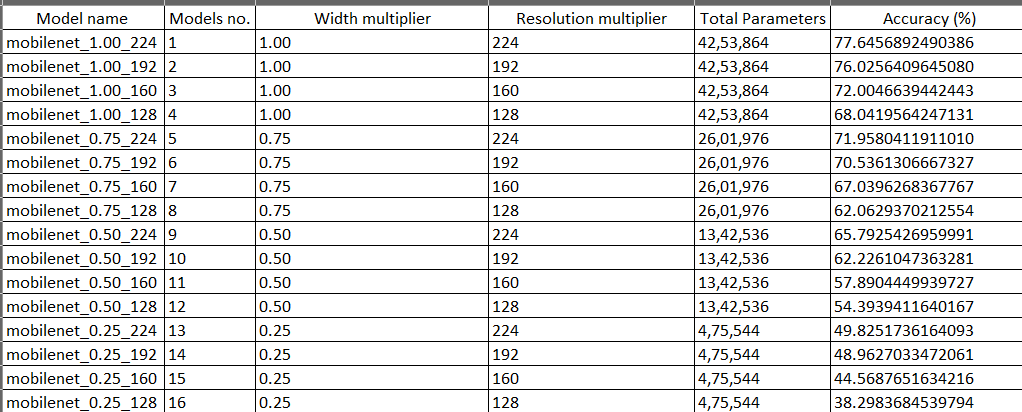